# Classifieur bayésien

In [698]:
import pandas as pa
import numpy as np

dataset = pa.read_csv("https://www.labri.fr/perso/zemmari/datasets/salmon_seabass.csv", sep=";")
df = pa.DataFrame(dataset)

df.head()

,lightness,width,species
0,9.710457,8.673699,0
1,6.528089,7.330887,0
2,1.770695,7.599677,0
3,4.819293,7.328198,0
4,6.769638,8.575629,0


In [699]:
# class = data type
# col `species` is class
# 0 : il s'agit d'un saumon
# 1 : il s'agit d'un bar

sizeVTSaumon = np.count_nonzero(df["species"] == 0)
sizeVTBar = np.count_nonzero(df["species"] == 1)

print("Saumon :", sizeVTSaumon, "Bar :", sizeVTBar)

Saumon : 1000 Bar : 500


## Exercice 1

In [700]:
data = df.sample(frac=1)

In [701]:
X = data["width"]
Y = data["species"]

In [702]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print(len(X_train), str(len(X_train) * 100 / len(X)) + "%")
print(len(X_test), str(len(X_test) * 100 / len(X)) + "%")

1200 80.0%
300 20.0%


### Classifieur ML

In [703]:
# mean is average in statistics (la moyenne)
meanSaumon = np.mean(X_train[Y_train == 0])
meanBar = np.mean(X_train[Y_train == 1])

# l'écart type = standard deviation, the variance : a measure of the spread of a distribution, of the array elements.
stdSaumon = np.std(X_train[Y_train == 0], 0)
stdBar = np.std(X_train[Y_train == 1], 0)
print(meanSaumon, meanBar, stdSaumon, stdBar)

8.04381851137502 12.048605103807947 1.0093293769523644 2.0611879391837036


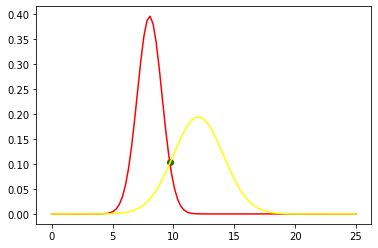

In [704]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
norm = ss.norm # normal low package

x = np.linspace(0, 25, 100)

yn = norm.pdf(x, meanSaumon, stdSaumon)
plt.plot(x, yn, c="red")

yn = norm.pdf(x, meanBar, stdBar)
plt.plot(x, yn, c="yellow")

plt.scatter(9.75, norm.pdf(9.75, meanBar, stdBar), c="green")

- La frontière de décision est 9.75

In [705]:
width = 12
if norm.pdf(width, meanSaumon, stdSaumon) > norm.pdf(width, meanBar, stdBar) :
  print("Saumon")
else:
  print("Bar")

Bar


- Un poisson de longueur 12 est un bar

In [706]:
from sklearn.metrics import confusion_matrix

Y_pred = [norm.pdf(x, meanSaumon, stdSaumon) < norm.pdf(x, meanBar, stdBar) for x in X_test]

cm = confusion_matrix(Y_test, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[199   8]
 [ 12  81]]
93.33%


### Classifieur MAP

la vraisemblance de l c'est $\mathbb{P}(l| saumon)$

la probabilités a posteriori (map) = le plus grand entre $\mathbb{P}(saumon|l)=\frac{\mathbb{P}(l| saumon) \cdot\mathbb{P}(saumon)}{\mathbb{P}(l)}$ et $\frac{\mathbb{P}(l|bar) \cdot\mathbb{P}(bar)}{\mathbb{P}(l)}$ donc le plus grand entre $\mathbb{P}(l| saumon) \cdot\mathbb{P}(saumon)$ et $\mathbb{P}(l|bar) \cdot\mathbb{P}(bar)$

In [707]:
def classify(l):
  vraisemblanceSaumon = (1/np.sqrt(2*np.pi))*np.exp((-(l-5)**2)/2)
  vraisemblanceBar = (1/(2*np.sqrt(2*np.pi)))*np.exp((-(l-10)**2)/8)
  probaSaumon = 2/3
  probaBar = 1/3

  return vraisemblanceSaumon * probaSaumon < vraisemblanceBar * probaBar


In [708]:
if classify(12):
  print("Bar")
else:
  print("Saumon")

Bar


In [709]:
Y_pred = [classify(x) for x in X]

cm = confusion_matrix(Y, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

[[197 803]
 [  4 496]]
46.20%


## Exercice 2

In [710]:
X = data[["width", "lightness"]]
Y = data["species"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print(len(X_train), str(len(X_train) * 100 / len(X)) + "%")
print(len(X_test), str(len(X_test) * 100 / len(X)) + "%")

1200 80.0%
300 20.0%


### Classifieur ML

In [711]:
# mean is average in statistics (la moyenne)
meanSaumon = np.mean(X_train[Y_train == 0])
meanBar = np.mean(X_train[Y_train == 1])

# l'écart type = standard deviation, the sqrt variance : a measure of the spread of a distribution, of the array elements.
stdSaumon = np.std(X_train[Y_train == 0], 0)
stdBar = np.std(X_train[Y_train == 1], 0)

print(meanSaumon, meanBar, stdSaumon, stdBar)

width        8.043819
lightness    4.966356
dtype: float64 width        12.048605
lightness    10.845449
dtype: float64 width        1.009329
lightness    1.860602
dtype: float64 width        2.061188
lightness    3.941980
dtype: float64


In [712]:
probas = [len(Y_train.values[Y_train.values == 0]) / len(Y_train.values), len(Y_train.values[Y_train.values == 1]) / len(Y_train.values)]

def predict(item):
  p_s = 1 * norm.pdf(item["width"], meanSaumon["width"], stdSaumon["width"])
  p_b = 1 * norm.pdf(item["width"], meanBar["width"], stdBar["width"])

  p_s *= norm.pdf(item["lightness"], meanSaumon["lightness"], stdSaumon["lightness"])
  p_b *= norm.pdf(item["lightness"], meanBar["lightness"], stdBar["lightness"])

  if p_s > p_b :
    return 0
  return 1

In [713]:
predict({
  "width": 1.81,
  "lightness" : 59
})

1

In [714]:
print("Efficiency")
Y_pred = [predict({"width": x[0], "lightness": x[1]}) for x in X_test.values]

cm = confusion_matrix(Y_test.values, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

Efficiency
[[202   5]
 [  7  86]]
96.00%


### Classifieur MAP

In [715]:
def classify2(item):
  probas = [len(Y_train.values[Y_train.values == 0]) / len(Y_train.values), len(Y_train.values[Y_train.values == 1]) / len(Y_train.values)]

  p_s = 1 * norm.pdf(item["width"], meanSaumon["width"], stdSaumon["width"])
  p_b = 1 * norm.pdf(item["width"], meanBar["width"], stdBar["width"])

  p_s *= norm.pdf(item["lightness"], meanSaumon["lightness"], stdSaumon["lightness"])
  p_b *= norm.pdf(item["lightness"], meanBar["lightness"], stdBar["lightness"])

  if probas[0] * p_s > probas[1] * p_b :
    return 0
  return 1

In [716]:
from sklearn.metrics import confusion_matrix

print("Efficiency")
Y_pred = [classify2({"width": x[0], "lightness": x[1]}) for x in X_test.values]

cm = confusion_matrix(Y_test.values, Y_pred)
print(cm)
acc = np.sum(np.diag(cm))/np.sum(cm)

print("{:.2%}".format(acc))

Efficiency
[[205   2]
 [  7  86]]
97.00%


## Exercice 3

In [717]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train.values, Y_train.values)

GaussianNB()

In [722]:
Y_pred = nb.predict(X_test.values)

cm = confusion_matrix(Y_test.values, Y_pred)
print(cm)

from sklearn.metrics import accuracy_score
print("{:.2%}".format(accuracy_score(Y_test, Y_pred)))

[[205   2]
 [  7  86]]
97.00%


In [719]:
predF = nb.predict([[1.81, 59]])

if predF[0]:
  print("Bar")
else:
  print("Saumon")

Bar
